In [ ]:
pip install jamo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Embedding, RepeatVector, Concatenate, Reshape, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from scipy.io.wavfile import read, write
import librosa
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data_path = '/content/drive/MyDrive/dataset/voice/ljs_audio_text_train_filelist.txt'
val_data_path =  '/content/drive/MyDrive/dataset/voice/ljs_audio_text_val_filelist.txt'
wav_path = '/content/drive/MyDrive/dataset/voice/'

In [ ]:
import random

def load_data(file_path, wav_path, subset_ratio=None):
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        if subset_ratio:
            random.shuffle(lines)
            num_samples = int(len(lines) * subset_ratio)
            lines = lines[:num_samples]
        for line in lines:
            wav_file, text = line.strip().split("|")
            wav_file_path = os.path.join(wav_path, wav_file[10:])
            audio, _ = librosa.load(wav_file_path, sr=None)
            data.append((audio, text))
    return data

# def load_wav(wav_path):
#     sr, wav = read(wav_path)
#     # Convert stereo audio to mono if necessary
#     if wav.ndim > 1:
#         wav = wav[:, 0]
#     return sr, wav

# def preprocess_data(data):
#     preprocessed_data = []
#     for wav_path, text in data:
#         sr, wav = load_wav(wav_path)
#         # Resample audio to 22,050Hz if necessary
#         wav = librosa.resample(wav, sr, 22050)
#         preprocessed_data.append((wav, text))
#     return preprocessed_data

In [ ]:
# 데이터셋이 많아 학습 및 로딩시간이 매우 기므로 20%만 랜덤 추출 (시험용)

train_data = load_data(train_data_path, wav_path, subset_ratio=0.2)
val_data = load_data(val_data_path, wav_path, subset_ratio=0.2)

In [ ]:
print(train_data[0][0].shape)
print(train_data[0][1])

(50936,)
모르는 사람이랑도 페이스북 친구 하시나요?


In [ ]:
print(val_data[0][0].shape)
print(val_data[0][1])

(44762,)
오늘은 우리나라의 큰 명절입니다.


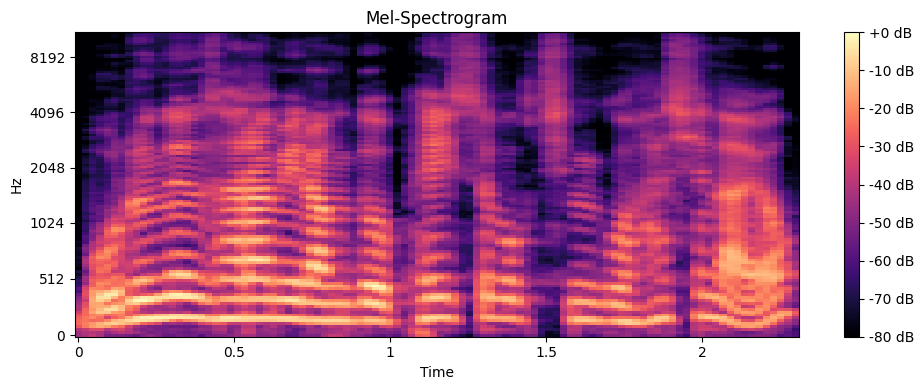

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

# 오디오 데이터 로드
audio_data = train_data[0][0]

# Mel Spectrogram 계산
S = librosa.feature.melspectrogram(y=audio_data, sr=22050)

# 로그 Mel Spectrogram 계산
log_S = librosa.power_to_db(S, ref=np.max)

# 그림 그리기
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=22050, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.savefig('Mel-Spectrogram example.png')
plt.show()

In [ ]:
def calculate_average_and_max_length(matrix_list):
    total_length = 0
    max_length = 0
    num_matrices = len(matrix_list)

    for matrix in matrix_list:
        matrix_length = len(matrix)
        total_length += matrix_length

        if matrix_length > max_length:
            max_length = matrix_length

    average_length = total_length / len(matrix_list)

    return average_length, max_length

# 평균과 최대 길이 계산
average_length, max_length = calculate_average_and_max_length(train_data[:][0])
print("평균 길이:", average_length)
print("최대 길이:", max_length)

평균 길이: 25479.5
최대 길이: 50936


In [ ]:
max_text_length = 140 # 최대 문장 길이
vocab_size = 10000 # 단어 사전 크기
embedding_dim = 256 # 임베딩 차원
latent_dim = 64 # 잠재 공간 차원
output_length = 100 # 출력 길이
output_dim = 400  # 출력 차원
max_audio_length = 200   # 음성 길이

In [ ]:
from keras.models import Model
from keras import backend as K
from keras.layers.core import Lambda

'''
latent_dim = 64

# Encoder
text_input = Input(shape=(max_text_length,), dtype='float32')  # Update the input type to float32
text_encoded = Reshape((max_text_length, 1))(text_input)
text_encoded = LSTM(latent_dim)(text_encoded)

audio_input = Input(shape=(audio_length, output_dim))
audio_encoded = LSTM(latent_dim)(audio_input)

concatenated = Concatenate()([text_encoded, audio_encoded])

# VAE part
z_mean = Dense(latent_dim)(concatenated)
z_log_var = Dense(latent_dim)(concatenated)

# Sampling
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_input = RepeatVector(max_text_length)(z)
decoder_text_input = Input(shape=(max_text_length,), dtype='int32')
decoder_embedded_text = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_text_input)
concatenated_decoder_input = Concatenate(axis=2)([decoder_input, decoder_embedded_text])
decoded = LSTM(latent_dim, return_sequences=True)(concatenated_decoder_input)
decoded = TimeDistributed(Dense(output_dim))(decoded)

# Slice the output tensor to match desired sequence length (100, 256)
decoded = Lambda(lambda x: x[:, :100, :])(decoded)

# Create models
encoder = Model([text_input, audio_input], z_mean)
decoder = Model([decoder_text_input, decoder_input], decoded)

output = decoder([decoder_text_input, decoder_input])
vae = Model([text_input, decoder_text_input, audio_input], output)
'''

# # Encoder
# text_input = Input(shape=(max_text_length,), dtype='float32')
# text_encoded = Reshape((max_text_length, 1))(text_input)
# text_encoded = LSTM(latent_dim)(text_encoded)

# audio_input = Input(shape=(max_audio_length, output_dim))  # Update the audio input shape
# audio_encoded = LSTM(latent_dim)(audio_input)

# concatenated = Concatenate()([text_encoded, audio_encoded])

# # VAE part
# z_mean = Dense(latent_dim)(concatenated)
# z_log_var = Dense(latent_dim)(concatenated)

# # Sampling
# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
#     return z_mean + K.exp(z_log_var / 2) * epsilon

# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# # Decoder
# decoder_input = RepeatVector(max_audio_length)(z)

# decoder_text_input = Input(shape=(max_text_length,), dtype='int32')
# # Pass the text input through an Embedding layer before the LSTM layer
# # Here, replace 'embedding_dim' with the desired size of your embeddings
# decoder_text_embedded = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_text_input)
# # Pass the embedded text input through an LSTM layer
# # Set return_sequences=False so the output is 2D
# decoder_text_encoded = LSTM(latent_dim, return_sequences=False)(decoder_text_embedded)

# # Now that the output of the LSTM is 2D, we can use RepeatVector
# decoder_text_encoded = RepeatVector(max_audio_length)(decoder_text_encoded)

# # Concatenate the decoder input and the encoded text
# concatenated_decoder_input = Concatenate(axis=2)([decoder_input, decoder_text_encoded])

# # Pass the concatenated input through another LSTM layer
# decoded = LSTM(latent_dim, return_sequences=True)(concatenated_decoder_input)

# # Use a Dense layer to get the final output shape
# decoded = TimeDistributed(Dense(output_dim))(decoded)  # Update the Dense layer's output dimension

# # Adjust the output to match the desired shape
# decoded = Reshape((max_audio_length, output_dim))(decoded)  # Update the reshape layer

# # Create models
# encoder = Model([text_input, audio_input], z_mean)
# decoder = Model([decoder_text_input, decoder_input], decoded)

# output = decoder([decoder_text_input, decoder_input])
# vae = Model([text_input, decoder_text_input, audio_input], output)

latent_dim = 64

# Encoder
text_input = Input(shape=(140,), dtype='float32')  # Updated text input shape
text_encoded = Reshape((140, 1))(text_input)  # Updated reshape
text_encoded = LSTM(latent_dim)(text_encoded)

audio_input = Input(shape=(200, 400))  # Updated audio input shape
audio_encoded = LSTM(latent_dim)(audio_input)

# Concatenate the encoded text and audio
encoded = Concatenate()([text_encoded, audio_encoded])

# VAE part
z_mean = Dense(latent_dim)(encoded)
z_log_var = Dense(latent_dim)(encoded)

# Sampling
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_input = RepeatVector(200)(z)  # Updated to match the desired sequence length
decoded = LSTM(latent_dim, return_sequences=True)(decoder_input)
decoded = Dense(400)(decoded)  # The output dimension should match the audio data

# Create the models
encoder = Model([text_input, audio_input], z_mean)
decoder = Model(z, decoded)
vae = Model([text_input, audio_input], decoder(z))

In [ ]:
# 모델 생성
model = vae
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 140)]        0           []                               
                                                                                                  
 reshape_7 (Reshape)            (None, 140, 1)       0           ['input_15[0][0]']               
                                                                                                  
 input_16 (InputLayer)          [(None, 200, 400)]   0           []                               
                                                                                                  
 lstm_13 (LSTM)                 (None, 64)           16896       ['reshape_7[0][0]']              
                                                                                           

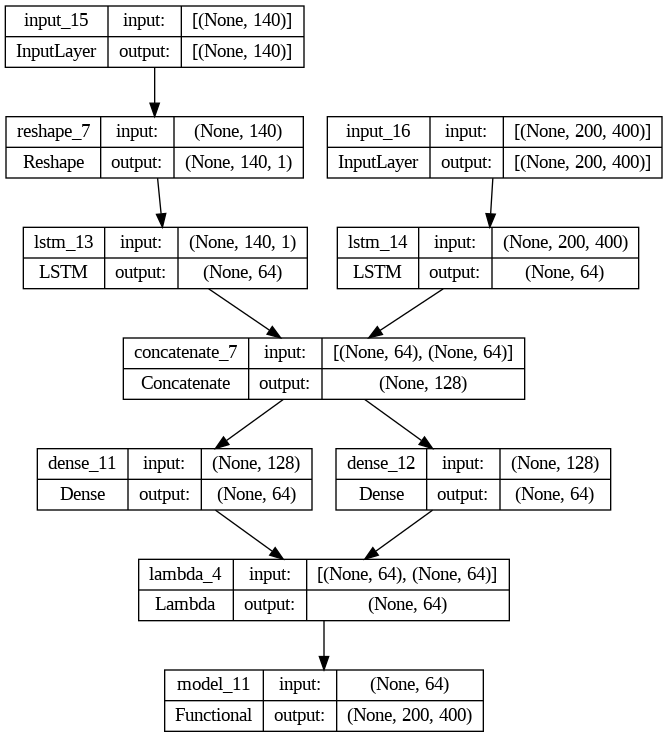

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# 한글을 초성 중성 종성으로 분리한 후 각각 숫자로 임베딩

import re
import unicodedata

CHOSUNGS = "".join([chr(_) for _ in range(0x1100, 0x1113)])
JOONGSUNGS = "".join([chr(_) for _ in range(0x1161, 0x1176)])
JONGSUNGS = "".join([chr(_) for _ in range(0x11A8, 0x11C3)])
ALPHABETS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
NUMBERS = "0123456789"
SPECIALS = " ?!"

ALL_VOCABS = "".join([
    CHOSUNGS,
    JOONGSUNGS,
    JONGSUNGS,
    ALPHABETS,
    NUMBERS,
    SPECIALS
])
VOCAB_DICT = {
    "_": 0,
    "~": 1,
}

for idx, v in enumerate(ALL_VOCABS):
    VOCAB_DICT[v] = idx + 2


def normalize(text):
    text = unicodedata.normalize('NFKD', text)
    text = text.upper()
    text = text.replace('%', unicodedata.normalize('NFKD', '퍼센트'))
    regex = unicodedata.normalize('NFKD', r"[^ \u11A8-\u11FF\u1100-\u115E\u1161-\u11A70-9A-Z?!]")
    text = re.sub(regex, '', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text


def tokenize(text, encoding: bool = True):
    tokens = list()

    for t in text:
        if encoding:
            tokens.append(VOCAB_DICT[t])
        else:
            tokens.append(t)

    if encoding:
        tokens.append(VOCAB_DICT['~'])
    else:
        tokens.append('~')

    return tokens


def text_to_sequence(text):
    text = normalize(text)
    tokens = tokenize(text, encoding=True)
    return tokens

# Example usage
text = "안녕하세요"
embedding = text_to_sequence(text)
print(embedding)

[13, 21, 45, 4, 27, 62, 20, 21, 11, 26, 13, 33, 1]


In [ ]:
import librosa
from tensorflow.keras.preprocessing.sequence import pad_sequences

def pad_2d(data, size):
    if data.shape[1] < size:
        padding = np.zeros((data.shape[0], size - data.shape[1]))
        data = np.hstack((data, padding))
    return data

def audio_to_mel_spectrogram(audio, sr=16000, n_fft=400, hop_length=160, n_mels=128, length=256):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spectrogram = pad_2d(mel_spectrogram, length)  # Ensure the output has a fixed size
    return librosa.power_to_db(mel_spectrogram, ref=np.max)

In [ ]:
# Preprocess data(text)
train_wavs, train_texts = zip(*train_data)
val_wavs, val_texts = zip(*val_data)

max_audio_length = 200
output_dim = 400

# Convert text to sequence
train_texts = [text_to_sequence(text) for text in train_texts]
val_texts = [text_to_sequence(text) for text in val_texts]

# Padding sequences for train and val texts
train_texts = pad_sequences(train_texts, dtype='int32', padding='post', maxlen=140)
val_texts = pad_sequences(val_texts, dtype='int32', padding='post', maxlen=140)

In [ ]:
# Padding and reshaping train and val wavs
train_wavs_mel = []
for audio in train_wavs:
    if len(audio.shape) == 1:
        audio = audio[:80000]  # Cut if size exceeds 80000
        audio = np.pad(audio, (0, max(0, 80000 - len(audio))))  # Pad if size is less than 80000
        audio = audio.reshape(-1, 400)[:200, :]  # Reshape to 2D and cut to fit into (200, 400)
    train_wavs_mel.append(audio)

val_wavs_mel = []
for audio in val_wavs:
    if len(audio.shape) == 1:
        audio = audio[:80000]  # Cut if size exceeds 80000
        audio = np.pad(audio, (0, max(0, 80000 - len(audio))))  # Pad if size is less than 80000
        audio = audio.reshape(-1, 400)[:200, :]  # Reshape to 2D and cut to fit into (200, 400)
    val_wavs_mel.append(audio)

train_wavs_mel = np.array(train_wavs_mel)
val_wavs_mel = np.array(val_wavs_mel)

In [ ]:
train_wavs_mel[0].shape

(200, 400)

In [ ]:
# train_wavs_1d = train_wavs_mel[0].flatten() # 원상복귀

In [ ]:
# save_path = 'vae_model.h5'

# def train_tts_model(train_data, val_data, model, num_epochs, batch_size, learning_rate, save_path):
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     criterion = tf.keras.losses.MeanSquaredError()

#     # Preprocess data
#     train_wavs, train_texts = zip(*train_data)
#     train_texts = [text_to_sequence(text) for text in train_texts]

#     val_wavs, val_texts = zip(*val_data)
#     val_texts = [text_to_sequence(text) for text in val_texts]

#     max_audio_length = 100  # Depending on your data
#     output_dim = 256  # Depending on your data

#     train_wavs_mel = [audio_to_mel_spectrogram(audio)[:max_audio_length, :output_dim] for audio in train_wavs]
#     val_wavs_mel = [audio_to_mel_spectrogram(audio)[:max_audio_length, :output_dim] for audio in val_wavs]

#     # In case the Mel Spectrogram is shorter than max_audio_length or output_dim, pad the sequences
#     train_wavs_mel = pad_sequences(train_wavs_mel, dtype='float32', padding='post', maxlen=max_audio_length)
#     val_wavs_mel = pad_sequences(val_wavs_mel, dtype='float32', padding='post', maxlen=max_audio_length)

#     train_wavs_mel = np.reshape(train_wavs_mel, (-1, max_audio_length, output_dim))
#     val_wavs_mel = np.reshape(val_wavs_mel, (-1, max_audio_length, output_dim))

#     # Padding sequences
#     train_texts = pad_sequences(train_texts, dtype='int32', padding='post', maxlen=140)
#     val_texts = pad_sequences(val_texts, dtype='int32', padding='post', maxlen=140)

#     model.compile(optimizer=optimizer, loss=criterion)

#     checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_path, save_best_only=True, save_weights_only=True)

#     # Train the model
#     history = model.fit([train_texts, train_texts, train_wavs_mel], train_wavs_mel,
#                         validation_data=([val_texts, val_texts, val_wavs_mel], val_wavs_mel),
#                         epochs=num_epochs, batch_size=batch_size,
#                         callbacks=[checkpoint_callback], verbose=0)
#     return history

from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

save_dir = 'vae_model'
save_path = os.path.join(save_dir, 'vae_model.h5')

def train_tts_model(train_wavs_mel, train_texts, val_wavs_mel, val_texts, model, encoder, num_epochs, batch_size, learning_rate, save_path):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    criterion = tf.keras.losses.MeanSquaredError()

    model.compile(optimizer=optimizer, loss=criterion)

    # ModelCheckpoint for saving the best model
    checkpoint_callback = ModelCheckpoint(save_path, save_best_only=True, save_weights_only=True)

    # LambdaCallback for saving the z_mean values
    z_means = []
    save_z_mean = LambdaCallback(on_epoch_end=lambda epoch, logs: z_means.append(encoder.predict([train_texts, train_wavs_mel])))

    # Train the model
    history = model.fit([train_texts, train_wavs_mel], train_wavs_mel,
                        validation_data=([val_texts, val_wavs_mel], val_wavs_mel),
                        epochs=num_epochs, batch_size=batch_size,
                        callbacks=[checkpoint_callback, save_z_mean], verbose=0)

    # Save the z_means
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, 'z_means.npy'), np.array(z_means))

    return history


In [ ]:
# def data_generator(data, batch_size):
#     while True:
#         np.random.shuffle(data)
#         for i in range(0, len(data), batch_size):
#             batch_data = data[i:i+batch_size]
#             batch_wavs, batch_texts = [], []
#             for wav, text in batch_data:
#                 batch_wavs.append(wav)
#                 batch_texts.append(text)
#             yield np.array(batch_wavs), np.array

In [ ]:
num_epochs = 100
batch_size = 32
learning_rate = 0.001

# Train the model
history = train_tts_model(train_wavs_mel, train_texts, val_wavs_mel, val_texts, vae, encoder, num_epochs, batch_size, learning_rate, save_path)


19/19 [==============================] - 0s 7ms/step


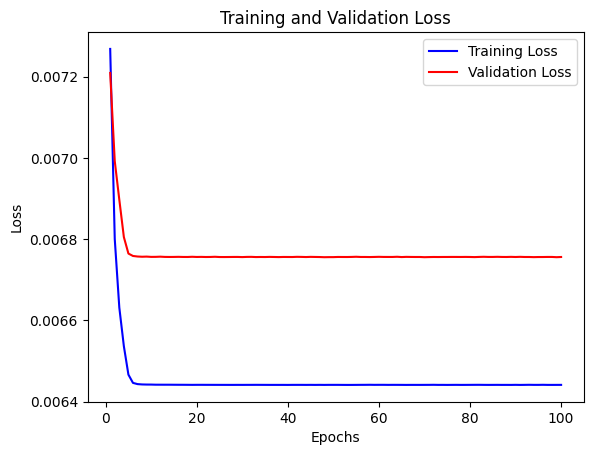

In [ ]:
# Save loss and validation loss data
np.savez("loss_history.npz", loss=history.history['loss'], val_loss=history.history['val_loss'])

# Plot the loss and validation loss curves
epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], 'b', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss_curve.png")
plt.show();

In [ ]:
model.save(save_path)

In [ ]:
def load_z_means(file_path):
    return np.load(file_path)

# Usage
z_means_file = os.path.join(save_dir, 'z_means.npy')
z_means = load_z_means(z_means_file)

In [ ]:
def generate_speech(text, model):
    # Preprocess the input text
    input_text = pad_sequences([text_to_sequence(text)], dtype='int32', padding='post', maxlen=140)

    # Create fake audio data with Gaussian noise
    fake_audio_data = np.random.normal(0, 1, (1, 200, 400))

    # Generate the speech from the model
    generated_speech = model.predict([input_text, fake_audio_data])

    return generated_speech

# Use the function to generate speech
text = "안녕하세요 반갑습니다. 저는 발표자입니다."
generated_speech = generate_speech(text, model)

1/1 [==============================] - 0s 43ms/step


In [ ]:
generated_speech.flatten().shape

(80000,)

In [ ]:
import soundfile as sf
reshaped_array = generated_speech.flatten()
mp3_file_path = "/content/drive/MyDrive/generated_voice.mp3"  # Replace with the desired output file path
sf.write(mp3_file_path, reshaped_array, 22050, format='mp3')